In [8]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [6]:
# --- 1. CONFIGURATION ---
TRAIN_DIR = 'RAF_DB_Dataset/train' 
TEST_DIR = 'RAF_DB_Dataset/test'

IMAGE_SIZE = 100 
BATCH_SIZE = 32 
NUM_CLASSES = 7
EPOCHS = 60
MODEL_FILE_NAME = 'raf_db_pretrained_model.h5'


In [3]:
# --- 2. DATA PREPARATION & GENERATORS ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading RAF-DB Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Loading RAF-DB Test Data...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


print(f"Class Mapping: {train_generator.class_indices}")


Loading RAF-DB Training Data...
Found 30023 images belonging to 7 classes.
Loading RAF-DB Test Data...
Found 4165 images belonging to 7 classes.
Class Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [21]:
# --- 3. MODEL ARCHITECTURE (Scaled Up) ---
model = Sequential()

# Block 1
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 4
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 5 (Extra block for 100x100 resolution)
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Head
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# --- 4. COMPILE & TRAIN ---

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    ModelCheckpoint(MODEL_FILE_NAME, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)
]

print("\n--- Starting Training on RAF-DB ---")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

print(f"Training Complete. Model saved as {MODEL_FILE_NAME}")

C:\Users\Adit Kapur\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Starting Training on RAF-DB ---


NameError: name 'train_generator' is not defined

In [6]:
model_json = model.to_json()
with open("raf_db_pretrained_model.json", "w") as json_file:
    json_file.write(model_json)

In [26]:
from keras.models import model_from_json

In [27]:
json_file = open("raf_db_pretrained_model.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("raf_db_pretrained_model.h5")

In [28]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [29]:
def extract_func(image):
    img = load_img(image, color_mode='grayscale', target_size=(100, 100))
    feature = np.array(img)
    feature = feature.reshape(1, 100, 100, 1)
    return feature / 255.0

In [31]:
image = r'RAF_DB_Dataset\test\disgust\aug_123660.png'
print("original image is of disgust")
img = extract_func(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
model prediction is  disgust


Loading model from raf_db_pretrained_model.h5...


Model loaded successfully!
Found 4165 test images.
Found 4165 validated image filenames belonging to 7 classes.
Running predictions...


C:\Users\Adit Kapur\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step
Generating Confusion Matrix...


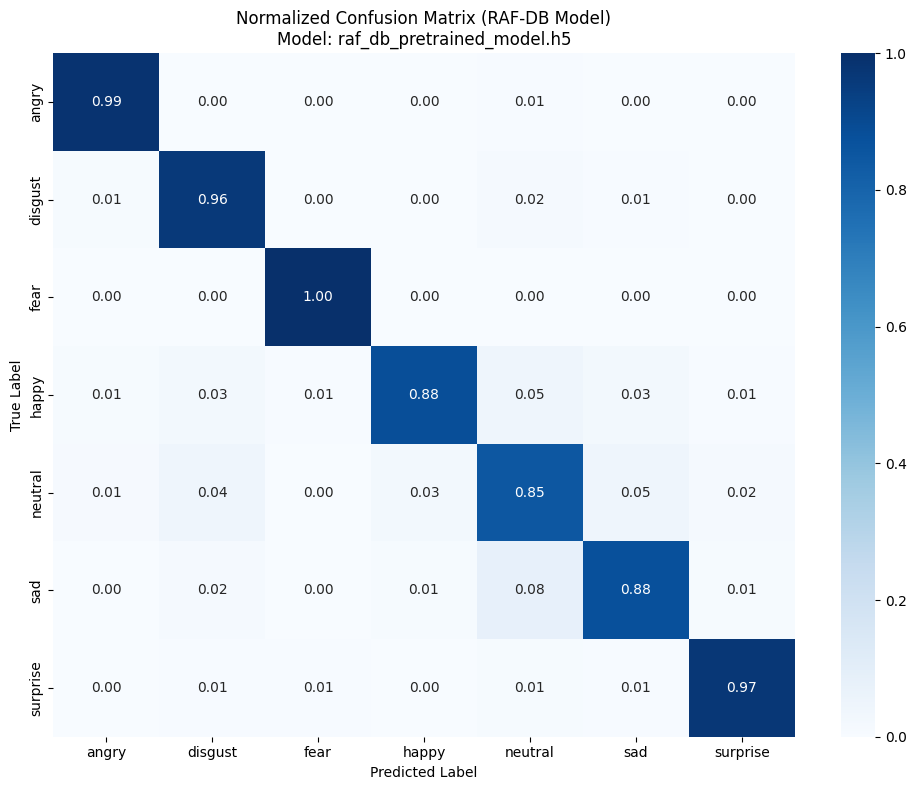


--- Classification Report ---
              precision    recall  f1-score   support

       angry       0.97      0.99      0.98       595
     disgust       0.91      0.96      0.93       595
        fear       0.98      1.00      0.99       595
       happy       0.96      0.88      0.92       595
     neutral       0.84      0.85      0.85       595
         sad       0.91      0.88      0.89       595
    surprise       0.97      0.97      0.97       595

    accuracy                           0.93      4165
   macro avg       0.93      0.93      0.93      4165
weighted avg       0.93      0.93      0.93      4165



In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1. CONFIGURATION ---
MODEL_PATH = 'raf_db_pretrained_model.h5' 
# Update this to the directory containing your RAF-DB test images
TEST_DIR = 'RAF_DB_Dataset/test' 
# RAF-DB model was trained on 100x100 images
IMAGE_SIZE = 100 
BATCH_SIZE = 32

# --- 2. LOAD MODEL ---
print(f"Loading model from {MODEL_PATH}...")
try:
    model = load_model(MODEL_PATH)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- 3. PREPARE TEST DATA ---
def create_dataframe(dir_path):
    image_paths = []
    labels = []
    
    if not os.path.exists(dir_path):
        print(f"Error: Directory '{dir_path}' not found.")
        exit()

    for label in os.listdir(dir_path):
        label_dir = os.path.join(dir_path, label)
        if os.path.isdir(label_dir):
            for imagename in os.listdir(label_dir):
                image_paths.append(os.path.join(label_dir, imagename))
                labels.append(label)
                    
    return pd.DataFrame({'image': image_paths, 'label': labels})

# Create dataframe
test_df = create_dataframe(TEST_DIR)
print(f"Found {len(test_df)} test images.")

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False # Critical for confusion matrix
)

# --- 4. GENERATE PREDICTIONS ---
print("Running predictions...")
predictions = model.predict(test_generator, verbose=1)
y_pred_indices = np.argmax(predictions, axis=1)
y_true_indices = test_generator.classes

# Get class labels from the generator to ensure correct order
class_map = test_generator.class_indices
class_labels = list(class_map.keys())

# --- 5. PLOT CONFUSION MATRIX ---
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_true_indices, y_pred_indices)

# Normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.title(f'Normalized Confusion Matrix (RAF-DB Model)\nModel: {MODEL_PATH}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- 6. REPORT ---
print("\n--- Classification Report ---")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_labels))